In [26]:
import urllib3
import json
import matplotlib.pyplot as plot
import numpy

In [27]:

PERIODS = '2019'
LOCALES = 'N1[all]'
PERCENTILES = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99, 100]

#Boundries query arguments
BOUND_AGGR = '7438'
BOUND_VAR = '10769'
BOUND_CLASSIF = '1019[49259,49260,49261,49262,49263,49264,49265,49266,49267,49268,49269,49270]'

#Income distribution query arguments
DISTRIBUTION_AGGR = '7530'
DISTRIBUTION_VAR = '10826'
DISTRIBUTION_CLASSIF = '1042[49271,49272,49273,49274,49275,49276,49277,49278,49279,49280,49281,49282]'

http = urllib3.PoolManager()

def query_ibge(aggregate, variables, classification, periods=PERIODS, locales=LOCALES):
    query_url = f'https://servicodados.ibge.gov.br/api/v3/agregados/{aggregate}/periodos/{periods}/variaveis/{variables}?localidades={locales}&classificacao={classification}'
    response = http.request('GET', query_url)
    if response.status != 200:
        print(f'ERRO: {response.status}')
        raise
    response_str = response.data.decode('utf-8')
    return json.loads(response_str)[0]['resultados']

In [28]:
income_classes = query_ibge(BOUND_AGGR, BOUND_VAR, BOUND_CLASSIF)
income_classes = [ float(percentile['series'][0]['serie'][PERIODS]) for percentile in income_classes ]

cumm_dist = query_ibge(DISTRIBUTION_AGGR, DISTRIBUTION_VAR, DISTRIBUTION_CLASSIF)
cumm_dist = [ float(percentile['series'][0]['serie'][PERIODS]) for percentile in cumm_dist ]
cumm_dist.append(100.0)

income_dist = [cumm_dist[0]]
for i in range(1, len(cumm_dist)):
    income_dist.append(cumm_dist[i] - cumm_dist[i-1])

Percentis: [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99, 100]
Classes de renda: [107.0, 211.0, 348.0, 498.0, 650.0, 826.0, 1002.0, 1282.0, 1733.0, 2723.0, 4209.0, 10365.0]
Distribuição de renda: [0.2, 0.6000000000000001, 2.0999999999999996, 3.1, 4.1, 5.4, 6.800000000000001, 8.3, 10.899999999999999, 15.700000000000003, 12.200000000000003, 18.19999999999999, 12.400000000000006]


<BarContainer object of 13 artists>

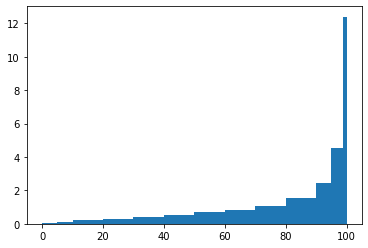

In [31]:
X = numpy.array(PERCENTILES)
widths = numpy.array([-5,  -5, -10, -10, -10, -10, -10, -10, -10, - 10,  -5,  -4,   -1])
Y = numpy.array(income_dist)/(-widths)

fig, ax = plot.subplots()
ax.bar(X, Y, align='edge', width=widths)